# Classificação de padrões

Para resolver os dois problemas, a mesma abordagem será dada a cada um deles. Ela consiste nos seguintes passos:

1) Dividir os dados para treinamento e teste
2) Definir as regras
3) Treinar a rede ANFIS
4) Validar a rede
5) Testar a capacidade de predição da rede

In [226]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.manifold import TSNE

import torch
from torch.utils.data import TensorDataset, DataLoader

import numpy as np

from copy import copy

import statistics as sts

import scipy.stats as st

from math import *

import pandas as pd

from sklearn.model_selection import KFold, cross_val_score

import skfuzzy as fuzz

import anfis

from membership import BellMembFunc, make_bell_mfs, GaussMembFunc, make_gauss_mfs

from experimental import *

dtype = torch.float

In [246]:
def acuracia(yc, yd):
    
    with torch.no_grad():
        erromedio = F.mse_loss(yc, yd)
        raizerromedio = torch.sqrt(erromedio).item()
        erropercento= torch.mean(100. * torch.abs((yc - yd)/ yd))
    return(erromedio, raizerromedio, erropercento)


def corrige_dados(x, y, batch = 1024, shuft= True):
    
    x_novo = torch.zeros(x.shape)
    y_novo = torch.zeros((len(y), 1))
    for i in range(len(x)):
            x_novo[i] = torch.tensor(x[i,:])
            y_novo[i] = torch.tensor(y[i])
    novosdados = DataLoader(TensorDataset(x_novo, y_novo), batch_size=batch, shuffle=shuft)
    return novosdados

def modelo_anfis(x_trein):
    print (x_trein)
    
    definicoes_entrada = []
    for i in range(x_trein.shape[-1]):
        definicoes_entrada.append(('x'+str(i), make_gauss_mfs(0.3,[0.7])))

    definicoes_saida = ['y']
    modelo_anfis = anfis.AnfisNet('model_define', definicoes_entrada, definicoes_saida)
    return modelo_anfis
     
def treinamento_modelo(modelos_trein, dados_trein, epocas_trein, show_plots):
    
    optimizer = torch.optim.SGD(modelos_trein.parameters(), lr=1e-4, momentum=0.99)
    criterion = torch.nn.MSELoss(reduction='mean')
    
    erros = []
    print('### Training for {} epochs, training size = {} cases'.
          format(epocas_trein, dados_trein.dataset.tensors[0].shape[0]))
    for t in range(epocas_trein):
        for xt, ydtrein in dados_trein:
            yctrein = modelos_trein(xt)
            loss = criterion(yctrein, ydtrein)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        xt, ydtrein = dados_trein.dataset.tensors
        with torch.no_grad():
            modelos_trein.fit_coeff(xt, ydtrein)
        yctrein = modelos_trein(xt)
        erromedio, raizerro, percentoerro = calc_error(yctrein, ydtrein)
        erros.append(percentoerro)
        #progresso
        if t % 10 == 0:
            print('epoch {:4d}: Erro={:.5f}'.format(t, erromedio))
    if show_plots:
        plotErrors(erros)
        ydtrein = dados_trein.dataset.tensors[1]
        yctrein = modelos_trein(dados_trein.dataset.tensors[0])
        plotResults(ydtrein, yctrein)
    
def teste(modelos, dados, show_plots):
    x, yd = dados.dataset.tensors
    
    if show_plots:
        plot_all_mfs(modelos, x)
    print('Testando {} amostras'.format(x.shape[0]))
    
    yc_new = [] 
    yc = modelos(x)
    
    for i in yc:
        if i >= 0.5:
            yc_new.append(1)
        else:
            yc_new.append(0)
    
    yc = np.array(yc_new)
    precisao = precision_score(yd, yc)
    recall = recall_score(yd, yc)
    acuracia = accuracy_score(yd, yc)
    print('Acurácia={:.2f}%  Precisão={:.2f}% Recall={:.2f}%'.format(acuracia*100,precisao*100,recall*100))
    return acuracia, precisao, recall

## Breast Cancer Wisconsin Data Set

Os primeiros dados a serem analisados são os do dataset de cancer de mama de Wisconsin. Neste primeira etapa os dados são lidos, limpos de valores inconvenientes e separados em dados para teste e para treinamento.

In [247]:
dados=pd.read_csv('data.csv')
dados.pop('id').values

y=dados.pop('diagnosis').values

dados.pop('Unnamed: 32').values
x=dados.values
      
i=0
sizey=len(y)

labelencoder = LabelEncoder()
ynumeros = labelencoder.fit_transform(y)

x_trein, x_test, y_trein, y_test = train_test_split(x, ynumeros, test_size=0.3, random_state=42)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_trein = min_max_scaler.fit_transform(x_trein)
x_test = min_max_scaler.transform(x_test)

A próxima etapa é o treinamento utilizando o *k-folds*, que neste caso é composto de 10 pastas. A cada pasta um treinamento e validação é feito, com a acurácia sendo guardada para cada uma delas. No final é exibida a acurácia final do modelo.

  TRAIN: (358,) TEST: (40,)
  TRAIN: (358,) TEST: (40,)
  TRAIN: (358,) TEST: (40,)
  TRAIN: (358,) TEST: (40,)
  TRAIN: (358,) TEST: (40,)
  TRAIN: (358,) TEST: (40,)
  TRAIN: (358,) TEST: (40,)
  TRAIN: (358,) TEST: (40,)
  TRAIN: (359,) TEST: (39,)
  TRAIN: (359,) TEST: (39,)
[[0.29624369 0.27730808 0.28381849 ... 0.21839623 0.15474078 0.12800949]
 [0.27812332 0.22590463 0.26940639 ... 0.32576197 0.09520993 0.18006104]
 [0.34276899 0.14440311 0.355879   ... 0.40203193 0.24876799 0.31400475]
 ...
 [0.32317939 0.2404464  0.29937215 ... 0.12093614 0.17602996 0.05222109]
 [0.30799745 0.33513696 0.3052226  ... 0.66291727 0.31815494 0.42777213]
 [0.21984426 0.36557322 0.20605023 ... 0.2696299  0.22255076 0.11648016]]
### Training for 100 epochs, training size = 358 cases
epoch    0: Erro=0.17565
epoch   10: Erro=0.16775
epoch   20: Erro=0.14796
epoch   30: Erro=0.12222
epoch   40: Erro=0.10029
epoch   50: Erro=0.08417
epoch   60: Erro=0.07077
epoch   70: Erro=0.06118
epoch   80: Erro=0.05

epoch   20: Erro=0.13780
epoch   30: Erro=0.11652
epoch   40: Erro=0.09752
epoch   50: Erro=0.08510
epoch   60: Erro=0.07416
epoch   70: Erro=0.06687
epoch   80: Erro=0.05994
epoch   90: Erro=0.05437
Testando 359 amostras
Accurácia=95.82%  Precisão=98.36% Recall=90.23%
[0.9561128526645768, 0.9685534591194969, 0.9685534591194969, 0.9685534591194969, 0.9685534591194969, 0.9654088050314465, 0.9622641509433962, 0.9655172413793104, 0.9561128526645768, 0.9685534591194969, 0.9654088050314465, 0.9622641509433962, 0.9655172413793104, 0.9561128526645768, 0.9685534591194969, 0.9654088050314465, 0.9622641509433962, 0.9655172413793104, 0.9561128526645768, 0.9685534591194969, 0.9654088050314465, 0.9622641509433962, 0.9655172413793104, 0.9561128526645768, 0.9692737430167597, 0.9608938547486033, 0.9636871508379888, 0.9636871508379888, 0.9636871508379888, 0.9636871508379888, 0.9608938547486033, 0.9720670391061452, 0.9554317548746518, 0.958217270194986, 0.9692737430167597, 0.9608938547486033, 0.96368715

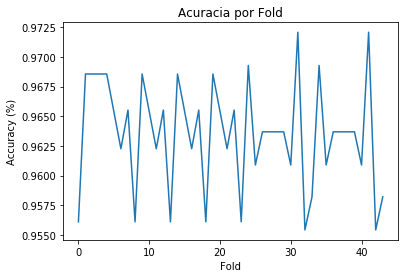

Testando 359 amostras
Accurácia=95.82%  Precisão=98.36% Recall=90.23%
Acurácia final   95.82%


In [252]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)
for trein, val in kf.split(x_trein):
    print("  TRAIN:", trein.shape, "TEST:", val.shape)
for trein, val in kf.split(x_trein):
    x_trein_novo, x_val_novo = x_trein[trein], x_trein[val]
    y_trein_novo, y_val_novo = y_trein[trein], y_trein[val]    

    rodarmodelo = modelo_anfis(x_trein_novo)
    dados_trein = corrige_dados(x_trein_novo, y_trein_novo)
    dados_val = corrige_dados(x_trein_novo, y_trein_novo)
    treinamento_modelo(rodarmodelo, dados_trein, 100, False)
    acuracia, precisao, recall = teste(rodarmodelo, dados_val, False)

    Acuracy.append(acuracia)
    Precision.append(precisao)
    Recall.append(recall)

print(Acuracy)

fig, ax = plt.subplots()
ax.plot(Acuracy)
ax.set(xlabel='Fold', ylabel='Accuracy (%)',
       title='Acuracia por Fold')
plt.show()

acuraciafinal, precisaofinal, recallfinal = teste(rodarmodelo, dados_val, False)
print('Acurácia final   {:.2f}%'.format(acuraciafinal*100))

Após a análise dos dados, é possível ver que uma boa acurácia foi atingida, já que ela se encontra acima dos $95\%$.

Com o código aplicado, pode-se dizer que obtiveram-se bons resultados, dado que a acurácia foi acima de 95%. Pode-se perceber, também foi percebido que a acurácia variou dentro dos folds estabelecidos, mas sempre mantendo o padrão de acima de 95%.

Para a segunda parte do trabalho, que trabalha com a base de dados Iris Species Data Set, será utilizado exatamente o mesmo código, com alteração no tratamento de dados. Dado que no bloco de execução do código, todas as variáveis dependem de x e ynumeros, os tratamentos serão feitos para que x e ynumeros obtenham novo valor a partir da nova base de dados.



## Iris Species Data Set

A mesma linha de raciocínio será aplicada a essa base de dados, também com 10 pastas no *k-folds*.

In [259]:
dados=pd.read_csv('iris.csv')
dados.pop('Id').values

dados['Species'] = dados['Species'].apply(lambda x: int(x =='Iris-setosa'))

y=dados.pop('Species').values

x=dados.values

i=0
sizey=len(y)

x_trein, x_test, y_trein, y_test = train_test_split(x, ynumeros, test_size=0.3, random_state=42)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_trein = min_max_scaler.fit_transform(x_trein)
x_test = min_max_scaler.transform(x_test)

  TRAIN: (94,) TEST: (11,)
  TRAIN: (94,) TEST: (11,)
  TRAIN: (94,) TEST: (11,)
  TRAIN: (94,) TEST: (11,)
  TRAIN: (94,) TEST: (11,)
  TRAIN: (95,) TEST: (10,)
  TRAIN: (95,) TEST: (10,)
  TRAIN: (95,) TEST: (10,)
  TRAIN: (95,) TEST: (10,)
  TRAIN: (95,) TEST: (10,)
[[0.58823529 0.36363636 0.71428571 0.58333333]
 [0.61764706 0.5        0.78571429 0.70833333]
 [0.67647059 0.45454545 0.58928571 0.54166667]
 [0.85294118 0.72727273 0.89285714 1.        ]
 [0.97058824 0.45454545 0.98214286 0.83333333]
 [0.38235294 0.45454545 0.60714286 0.58333333]
 [1.         0.36363636 1.         0.79166667]
 [0.44117647 0.31818182 0.53571429 0.375     ]
 [0.26470588 0.63636364 0.05357143 0.04166667]
 [0.20588235 0.68181818 0.03571429 0.08333333]
 [0.23529412 0.81818182 0.14285714 0.125     ]
 [0.20588235 0.         0.42857143 0.375     ]
 [0.58823529 0.31818182 0.67857143 0.70833333]
 [0.14705882 0.63636364 0.14285714 0.04166667]
 [0.20588235 0.45454545 0.08928571 0.04166667]
 [0.23529412 0.59090909 0

epoch   40: Erro=0.02016
epoch   50: Erro=0.02016
epoch   60: Erro=0.02016
epoch   70: Erro=0.02016
epoch   80: Erro=0.02016
epoch   90: Erro=0.02016
Testando 94 amostras
Accurácia=100.00%  Precisão=100.00% Recall=100.00%
[[0.35294118 0.18181818 0.46428571 0.375     ]
 [0.58823529 0.36363636 0.71428571 0.58333333]
 [0.61764706 0.5        0.78571429 0.70833333]
 [0.67647059 0.45454545 0.58928571 0.54166667]
 [0.85294118 0.72727273 0.89285714 1.        ]
 [0.41176471 0.40909091 0.55357143 0.5       ]
 [0.97058824 0.45454545 0.98214286 0.83333333]
 [0.38235294 0.45454545 0.60714286 0.58333333]
 [0.23529412 0.68181818 0.05357143 0.04166667]
 [0.44117647 0.31818182 0.53571429 0.375     ]
 [0.26470588 0.63636364 0.05357143 0.04166667]
 [0.20588235 0.68181818 0.03571429 0.08333333]
 [0.23529412 0.81818182 0.14285714 0.125     ]
 [0.20588235 0.         0.42857143 0.375     ]
 [0.58823529 0.31818182 0.67857143 0.70833333]
 [0.14705882 0.63636364 0.14285714 0.04166667]
 [0.20588235 0.45454545 0.

epoch   30: Erro=0.01965
epoch   40: Erro=0.01965
epoch   50: Erro=0.01965
epoch   60: Erro=0.01965
epoch   70: Erro=0.01965
epoch   80: Erro=0.01965
epoch   90: Erro=0.01965
Testando 94 amostras
Accurácia=100.00%  Precisão=100.00% Recall=100.00%
[[0.35294118 0.18181818 0.46428571 0.375     ]
 [0.61764706 0.5        0.78571429 0.70833333]
 [0.67647059 0.45454545 0.58928571 0.54166667]
 [0.85294118 0.72727273 0.89285714 1.        ]
 [0.41176471 0.40909091 0.55357143 0.5       ]
 [0.97058824 0.45454545 0.98214286 0.83333333]
 [0.38235294 0.45454545 0.60714286 0.58333333]
 [0.23529412 0.68181818 0.05357143 0.04166667]
 [1.         0.36363636 1.         0.79166667]
 [0.44117647 0.31818182 0.53571429 0.375     ]
 [0.20588235 0.68181818 0.03571429 0.08333333]
 [0.23529412 0.81818182 0.14285714 0.125     ]
 [0.58823529 0.31818182 0.67857143 0.70833333]
 [0.20588235 0.45454545 0.08928571 0.04166667]
 [0.23529412 0.59090909 0.10714286 0.16666667]
 [0.38235294 0.31818182 0.55357143 0.5       ]
 

epoch   40: Erro=0.01835
epoch   50: Erro=0.01835
epoch   60: Erro=0.01835
epoch   70: Erro=0.01835
epoch   80: Erro=0.01835
epoch   90: Erro=0.01835
Testando 95 amostras
Accurácia=100.00%  Precisão=100.00% Recall=100.00%
[[0.35294118 0.18181818 0.46428571 0.375     ]
 [0.58823529 0.36363636 0.71428571 0.58333333]
 [0.61764706 0.5        0.78571429 0.70833333]
 [0.85294118 0.72727273 0.89285714 1.        ]
 [0.41176471 0.40909091 0.55357143 0.5       ]
 [0.97058824 0.45454545 0.98214286 0.83333333]
 [0.38235294 0.45454545 0.60714286 0.58333333]
 [0.23529412 0.68181818 0.05357143 0.04166667]
 [1.         0.36363636 1.         0.79166667]
 [0.26470588 0.63636364 0.05357143 0.04166667]
 [0.20588235 0.68181818 0.03571429 0.08333333]
 [0.23529412 0.81818182 0.14285714 0.125     ]
 [0.20588235 0.         0.42857143 0.375     ]
 [0.58823529 0.31818182 0.67857143 0.70833333]
 [0.14705882 0.63636364 0.14285714 0.04166667]
 [0.20588235 0.45454545 0.08928571 0.04166667]
 [0.23529412 0.59090909 0.

epoch   10: Erro=0.01920
epoch   20: Erro=0.01920
epoch   30: Erro=0.01920
epoch   40: Erro=0.01920
epoch   50: Erro=0.01920
epoch   60: Erro=0.01920
epoch   70: Erro=0.01920
epoch   80: Erro=0.01920
epoch   90: Erro=0.01920
Testando 95 amostras
Accurácia=100.00%  Precisão=100.00% Recall=100.00%
[[0.35294118 0.18181818 0.46428571 0.375     ]
 [0.58823529 0.36363636 0.71428571 0.58333333]
 [0.61764706 0.5        0.78571429 0.70833333]
 [0.67647059 0.45454545 0.58928571 0.54166667]
 [0.85294118 0.72727273 0.89285714 1.        ]
 [0.41176471 0.40909091 0.55357143 0.5       ]
 [0.97058824 0.45454545 0.98214286 0.83333333]
 [0.38235294 0.45454545 0.60714286 0.58333333]
 [0.23529412 0.68181818 0.05357143 0.04166667]
 [1.         0.36363636 1.         0.79166667]
 [0.44117647 0.31818182 0.53571429 0.375     ]
 [0.26470588 0.63636364 0.05357143 0.04166667]
 [0.20588235 0.68181818 0.03571429 0.08333333]
 [0.23529412 0.81818182 0.14285714 0.125     ]
 [0.20588235 0.         0.42857143 0.375     

epoch   40: Erro=0.01968
epoch   50: Erro=0.01968
epoch   60: Erro=0.01968
epoch   70: Erro=0.01968
epoch   80: Erro=0.01968
epoch   90: Erro=0.01968
Testando 95 amostras
Accurácia=100.00%  Precisão=100.00% Recall=100.00%
[0.9561128526645768, 0.9685534591194969, 0.9685534591194969, 0.9685534591194969, 0.9685534591194969, 0.9654088050314465, 0.9622641509433962, 0.9655172413793104, 0.9561128526645768, 0.9685534591194969, 0.9654088050314465, 0.9622641509433962, 0.9655172413793104, 0.9561128526645768, 0.9685534591194969, 0.9654088050314465, 0.9622641509433962, 0.9655172413793104, 0.9561128526645768, 0.9685534591194969, 0.9654088050314465, 0.9622641509433962, 0.9655172413793104, 0.9561128526645768, 0.9692737430167597, 0.9608938547486033, 0.9636871508379888, 0.9636871508379888, 0.9636871508379888, 0.9636871508379888, 0.9608938547486033, 0.9720670391061452, 0.9554317548746518, 0.958217270194986, 0.9692737430167597, 0.9608938547486033, 0.9636871508379888, 0.9636871508379888, 0.9636871508379888

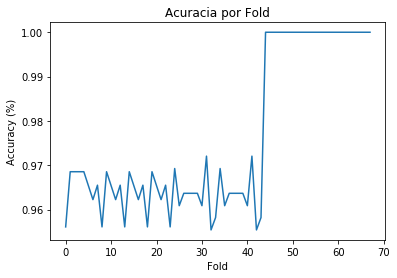

Testando 95 amostras
Accurácia=100.00%  Precisão=100.00% Recall=100.00%
Acurácia final   100.00%


In [262]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)
for trein, val in kf.split(x_trein):
    print("  TRAIN:", trein.shape, "TEST:", val.shape)
for trein, val in kf.split(x_trein):
    x_trein_novo, x_val_novo = x_trein[trein], x_trein[val]
    y_trein_novo, y_val_novo = y_trein[trein], y_trein[val]    

    rodarmodelo = modelo_anfis(x_trein_novo)
    dados_trein = corrige_dados(x_trein_novo, y_trein_novo)
    dados_val = corrige_dados(x_trein_novo, y_trein_novo)
    treinamento_modelo(rodarmodelo, dados_trein, 100, False)
    acuracia, precisao, recall = teste(rodarmodelo, dados_val, False)

    Acuracy.append(acuracia)
    Precision.append(precisao)
    Recall.append(recall)

print(Acuracy)

fig, ax = plt.subplots()
ax.plot(Acuracy)
ax.set(xlabel='Fold', ylabel='Accuracy (%)',
       title='Acuracia por Fold')
plt.show()

acuraciafinal, precisaofinal, recallfinal = teste(rodarmodelo, dados_val, False)
print('Acurácia final   {:.2f}%'.format(acuraciafinal*100))

Uma das diferenças entre essa basa de dados e a última é que nesta não haviam colunas com dados que não convêm. Também, como o interesse está na espécie Setosa, a esta foi atribuído o valor de $1$ e às demais, o de $0$.

O desempenho também foi extremamente satisfatório, porém, pela sua precisão de $100\%$, uma análise posterior deveria ser feita para avaliar a possibilidade desta mesma ter apresentado um sobreajuste (*overfitting*).